In [1]:
import pandas as pd
import numpy as np

In [2]:
! pip install -i https://test.pypi.org/simple/ group_12_krml_adv_mla_2024==2024.0.2.1

Looking in indexes: https://test.pypi.org/simple/


In [3]:
df_cleaned = pd.read_csv('../data/processed/df_cleaned.csv')

In [4]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46618 entries, 0 to 46617
Data columns (total 39 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GP         46618 non-null  int64  
 1   Min_per    46618 non-null  float64
 2   Ortg       46618 non-null  float64
 3   usg        46618 non-null  float64
 4   eFG        46618 non-null  float64
 5   ORB_per    46618 non-null  float64
 6   DRB_per    46618 non-null  float64
 7   AST_per    46618 non-null  float64
 8   TO_per     46618 non-null  float64
 9   FTM        46618 non-null  float64
 10  FT_per     46618 non-null  float64
 11  twoPM      46618 non-null  float64
 12  twoP_per   46618 non-null  float64
 13  TPM        46618 non-null  float64
 14  TP_per     46618 non-null  float64
 15  blk_per    46618 non-null  float64
 16  stl_per    46618 non-null  float64
 17  yr         46618 non-null  float64
 18  ht         46618 non-null  float64
 19  porpag     46618 non-null  float64
 20  year  

## Assess Baseline

In [5]:
y = df_cleaned.pop('drafted')

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [7]:
df_scaled = scaler.fit_transform(df_cleaned)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test,  y_train, y_test = train_test_split(df_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
from group_12_krml_adv_mla_2024.models.null import NullClassifier

In [10]:
base_model = NullClassifier()

In [11]:
y_base = base_model.fit_predict(y_train)

In [12]:
from group_12_krml_adv_mla_2024.models.performance import print_classifier_scores

print_classifier_scores(y_preds=y_base, y_actuals=y_train, average="weighted", set_name='Training')

Accuracy Training: 0.990481042526948
F1 Score Training: 0.9857443247586095


In [13]:
print_classifier_scores(y_preds=base_model.predict(y_test), y_actuals=y_test, average="weighted", set_name='Testing')

Accuracy Testing: 0.9904547404547405
F1 Score Testing: 0.9857049979093192


## Initial Gradient Boosting

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

In [15]:
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [16]:
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [17]:
y_train_preds = gb_classifier.predict(X_train)
y_val_preds = gb_classifier.predict(X_test)

In [18]:
from group_12_krml_adv_mla_2024.models.performance import print_classifier_outcomes
print_classifier_outcomes(y_val_preds, y_test, average="weighted")

Accuracy: 0.9905619905619906
F1 Score: 0.9892043608483605
Confusion Matrix:
[[9211   24]
 [  64   25]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9235
         1.0       0.51      0.28      0.36        89

    accuracy                           0.99      9324
   macro avg       0.75      0.64      0.68      9324
weighted avg       0.99      0.99      0.99      9324



In [19]:
print_classifier_scores(y_preds=y_train_preds, y_actuals=y_train, average="weighted", set_name='Training')

Accuracy Training: 0.9948785327398509
F1 Score Training: 0.9943875809247923


In [20]:
print_classifier_scores(y_preds=y_val_preds, y_actuals=y_test, average="weighted", set_name='Testing')

Accuracy Testing: 0.9905619905619906
F1 Score Testing: 0.9892043608483605


ROC AUC Score: 0.9744


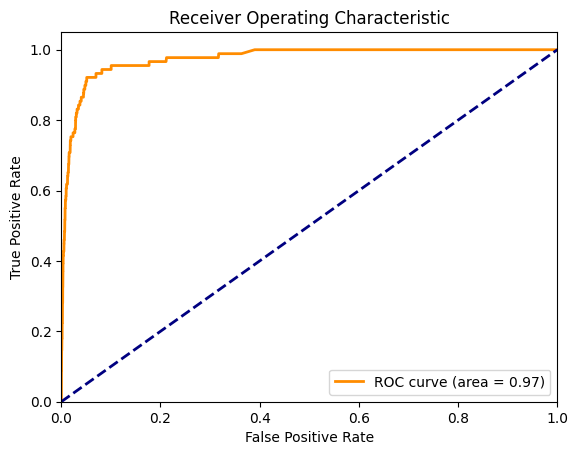

In [21]:
from group_12_krml_adv_mla_2024.models.performance import compute_roc_curve
import matplotlib.pyplot as plt

fpr, tpr, roc_auc = compute_roc_curve(gb_classifier, X_test, y_test, positive_class=1)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## RFE

In [22]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=gb_classifier, n_features_to_select=20)  # Select top 20 features
rfe.fit(X_train, y_train)

RFE(estimator=GradientBoostingClassifier(random_state=42),
    n_features_to_select=20)

In [23]:
selected_features = df_cleaned.columns[rfe.support_]

In [24]:
print(selected_features)

Index(['GP', 'Min_per', 'usg', 'TO_per', 'twoPM', 'twoP_per', 'yr', 'ht',
       'porpag', 'ast_tov', 'dunksmade', 'dporpag', 'bpm', 'obpm', 'dbpm',
       'gbpm', 'oreb', 'ast', 'stl', 'blk'],
      dtype='object')


In [25]:
df_rfe = df_cleaned[selected_features]

In [26]:
dfrfe_scaled = scaler.fit_transform(df_rfe)

X_trained, X_tested,  y_trained, y_tested = train_test_split(dfrfe_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
gb_classifier.fit(X_trained, y_trained)

GradientBoostingClassifier(random_state=42)

In [28]:
y_train_preds = gb_classifier.predict(X_trained)
y_val_preds = gb_classifier.predict(X_tested)

In [29]:
print_classifier_outcomes(y_val_preds, y_tested, average="weighted")

Accuracy: 0.9901329901329902
F1 Score: 0.9885247581577427
Confusion Matrix:
[[9211   24]
 [  68   21]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9235
         1.0       0.47      0.24      0.31        89

    accuracy                           0.99      9324
   macro avg       0.73      0.62      0.65      9324
weighted avg       0.99      0.99      0.99      9324



In [30]:
print_classifier_scores(y_preds=y_train_preds, y_actuals=y_trained, average="weighted", set_name='Training')

Accuracy Training: 0.9945835791280099
F1 Score Training: 0.9940150486678111


In [31]:
print_classifier_scores(y_preds=y_val_preds, y_actuals=y_tested, average="weighted", set_name='Testing')

Accuracy Testing: 0.9901329901329902
F1 Score Testing: 0.9885247581577427


ROC AUC Score: 0.9775


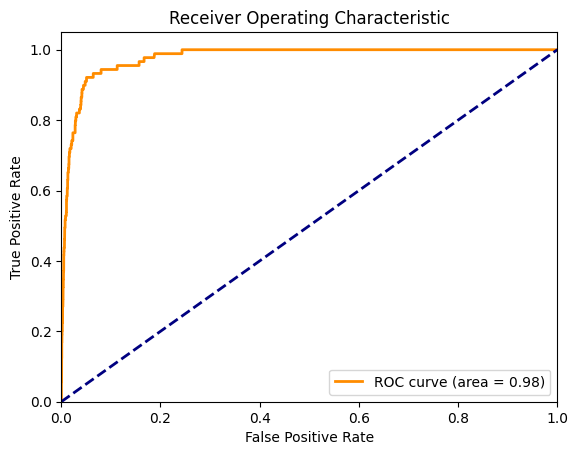

In [32]:
fpr, tpr, roc_auc = compute_roc_curve(gb_classifier, X_tested, y_tested, positive_class=1)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Run on Test set and Produce CSV for Kaggle

In [34]:
test_df = pd.read_csv('../data/processed/transformed_test_df.csv')

In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4970 entries, 0 to 4969
Data columns (total 38 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GP         4970 non-null   int64  
 1   Min_per    4970 non-null   float64
 2   Ortg       4970 non-null   float64
 3   usg        4970 non-null   float64
 4   eFG        4970 non-null   float64
 5   ORB_per    4970 non-null   float64
 6   DRB_per    4970 non-null   float64
 7   AST_per    4970 non-null   float64
 8   TO_per     4970 non-null   float64
 9   FTM        4970 non-null   int64  
 10  FT_per     4970 non-null   float64
 11  twoPM      4970 non-null   int64  
 12  twoP_per   4970 non-null   float64
 13  TPM        4970 non-null   int64  
 14  TP_per     4970 non-null   float64
 15  blk_per    4970 non-null   float64
 16  stl_per    4970 non-null   float64
 17  yr         4970 non-null   float64
 18  ht         4970 non-null   float64
 19  porpag     4970 non-null   float64
 20  year    

In [36]:
test_df = test_df[selected_features]

In [37]:
scaled_test_df = scaler.fit_transform(test_df)

In [38]:
scaled_test_df = scaled_test_df.astype('float32')

In [39]:
y_test_prob = gb_classifier.predict_proba(scaled_test_df)[:,1]

In [40]:
t_df = pd.read_csv('../data/raw/test.csv')
results_df = pd.DataFrame({'player_id':t_df['player_id'], 'drafted':y_test_prob})

In [41]:
results_df.to_csv('../data/external/GBCweek3.csv', index=False)